In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2022-12-08 07:37:43.942993: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import dask.dataframe as DDF
import cudf
import cupy as cp

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_dataset = tf.data.experimental.load("./acceptance-test.tfrecords").batch(1_000_000)
acceptance_model = tf.keras.models.load_model("/workarea/cloud-storage/anderlinil/models/acceptance")

acceptance_model.summary()

2022-12-08 07:37:47.332199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [4]:
import pickle
import os.path
preprocessing_file = "/workarea/cloud-storage/anderlinil/models/acceptance/tX.pkl"
with open(preprocessing_file, 'rb') as f:
    preprocessing_step = pickle.load(f)

/usr/local/miniconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.1.3 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/miniconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.1.3 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
def invert_column_transformer(column_transformer, preprocessed_X):
    preprocessed_split = {name: [None]*len(cols) for name, _, cols in column_transformer.transformers_}
        
    for iCol in range(preprocessed_X.shape[1]):
        name, transformer, cols = [(n, t, c) for n, t, c in column_transformer.transformers_ if iCol in c].pop()
        preprocessed_split[name][cols.index(iCol)] = preprocessed_X[:,iCol]
    
    X = []
    for name, algo, _ in column_transformer.transformers_:
        split = np.stack(preprocessed_split[name], axis=1)
        X.append(split if algo == 'passthrough' else algo.inverse_transform(split))
    
    return np.concatenate(X, axis=1)

In [6]:
#X, y = next(iter(test_dataset.as_numpy_iterator()))
#acceptance_vars = ["mc_x", "mc_y", "mc_z", "mc_p", "mc_px", "mc_py", "mc_is_e", "mc_is_mu", "mc_is_h", "mc_charge"]

def batch_to_df(batch):
    preprocessed_X, y = batch
    X = invert_column_transformer(preprocessing_step, preprocessed_X)

    y_hat = acceptance_model.predict(preprocessed_X, batch_size=len(X), verbose=False)
    df = pd.DataFrame(
        np.c_[X, y, y_hat],
        columns=['x',' y', 'z', 'log10_p', 'px', 'py', 'pz', 'is_e', 'is_mu', 'is_h', 'acceptance', 'predicted']
    )
    return df


ddf = DDF.from_map(batch_to_df, test_dataset.as_numpy_iterator())
ddf

INFO:tensorflow:Assets written to: ram://8f9fe893-3376-4cf0-bfc2-34414d01e2f9/assets


,x,y,z,log10_p,px,py,pz,is_e,is_mu,is_h,acceptance,predicted
npartitions=1,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
#mamba install -n base dask-cudf -y -c rapidsai -c conda-forge -c nvidia/label/cuda-11.7.0
cdf = ddf.map_partitions(cudf.DataFrame.from_pandas)

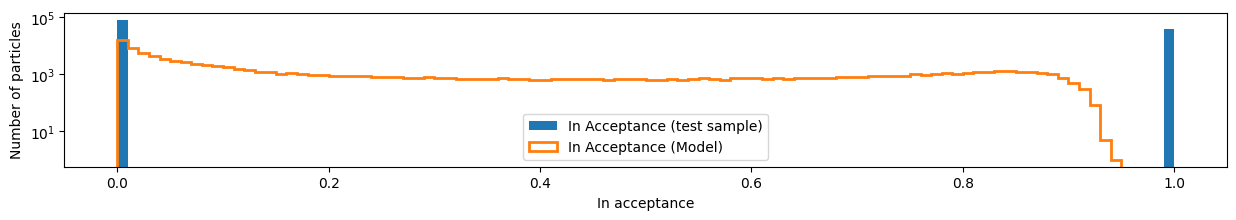

In [9]:
plt.figure(figsize=(15,2))
df = cdf.head(1_000_000)
plt.hist(df.acceptance, bins=np.linspace(0, 1, 101), label="In Acceptance (test sample)")
plt.hist(df.predicted, bins=np.linspace(0, 1, 101), label="In Acceptance (Model)", histtype='step', linewidth=2)
plt.legend()
plt.xlabel("In acceptance")
plt.ylabel("Number of particles")
plt.yscale('log')
plt.show()

In [10]:
def compute_eta(df):
    p = 10**df['log10_p']
    pt = (df.px**2 + df.py**2)**0.5
    theta = cp.arcsin(pt/p)
    df['eta'] = -cp.log(cp.tan(theta/2))
    return df

def compute_phi(df):
    df['phi'] = cp.arctan2(df.py, df.px)
    return df
    

cdf = (cdf.map_partitions(compute_eta)
          .map_partitions(compute_phi)
      )

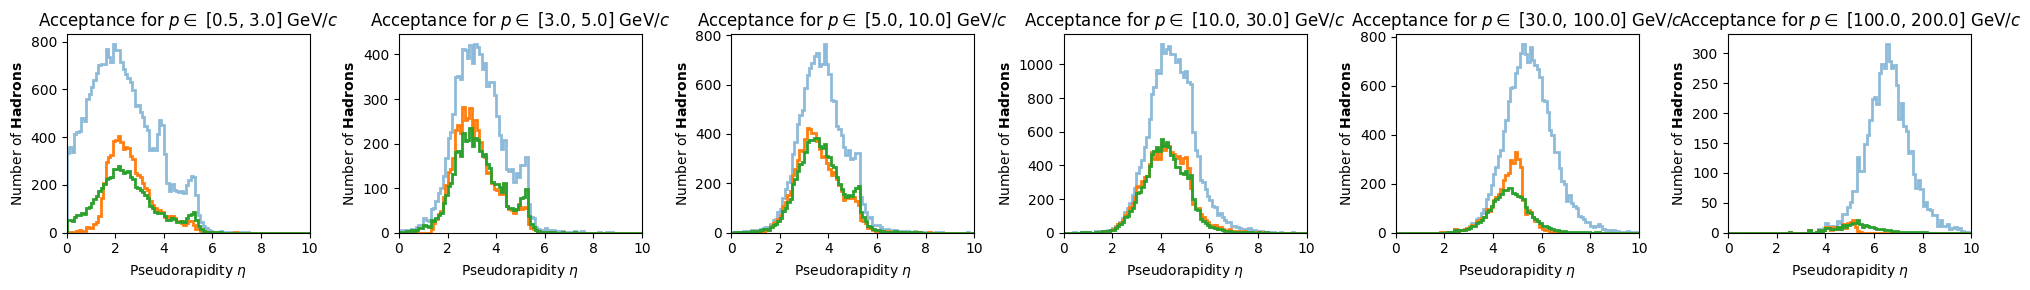

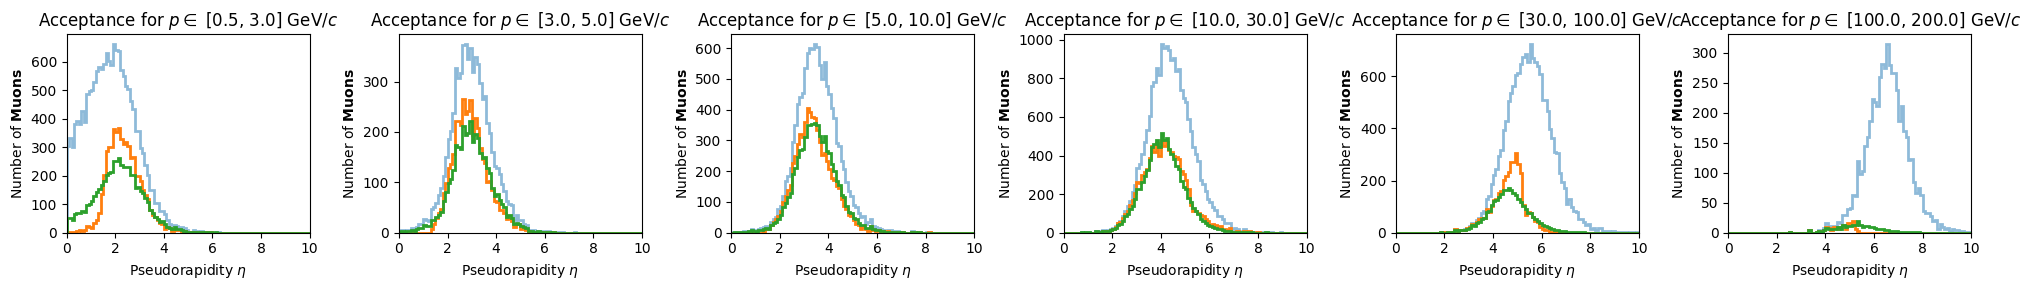

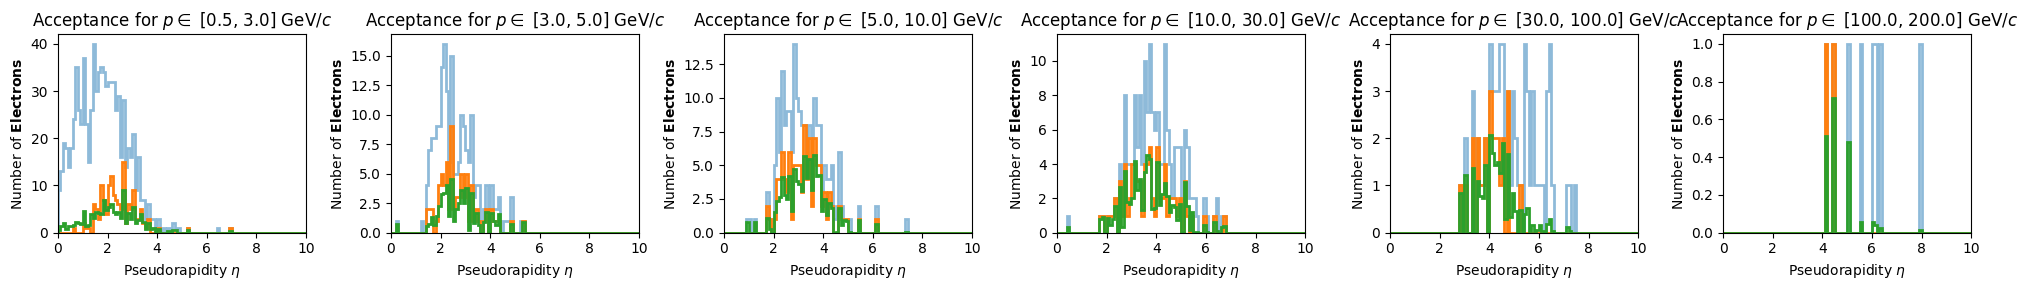

In [11]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"is_{part} and eta > 0 and eta < 12")[['acceptance', 'predicted', 'eta', 'log10_p']].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"log10_p > {np.log10(p_min)} and log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.eta.values, bins=np.linspace(0, 10, 101))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance').eta.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.eta.values, weights=bin_df.predicted.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Pseudorapidity $\eta$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()

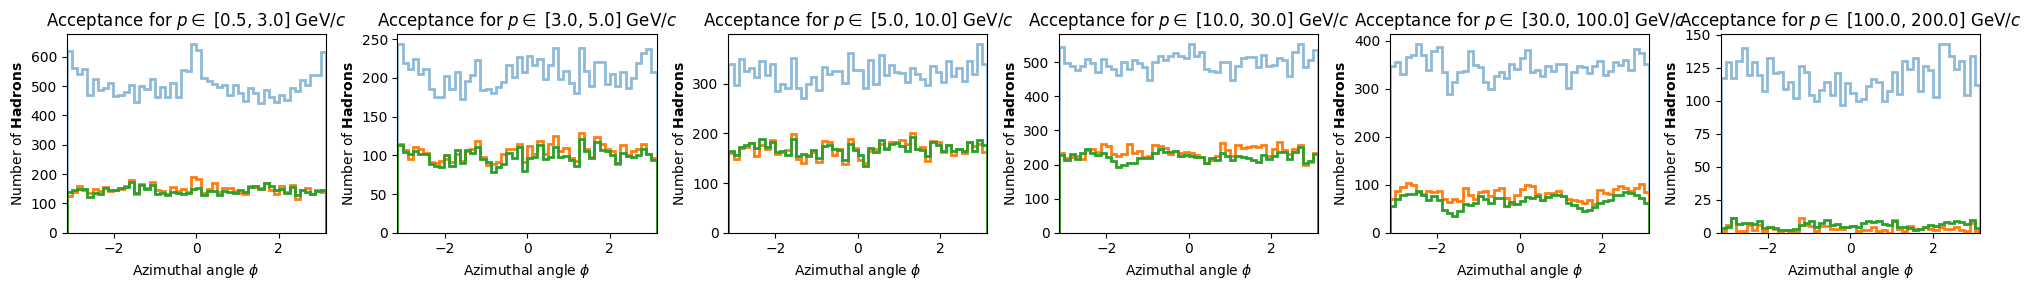

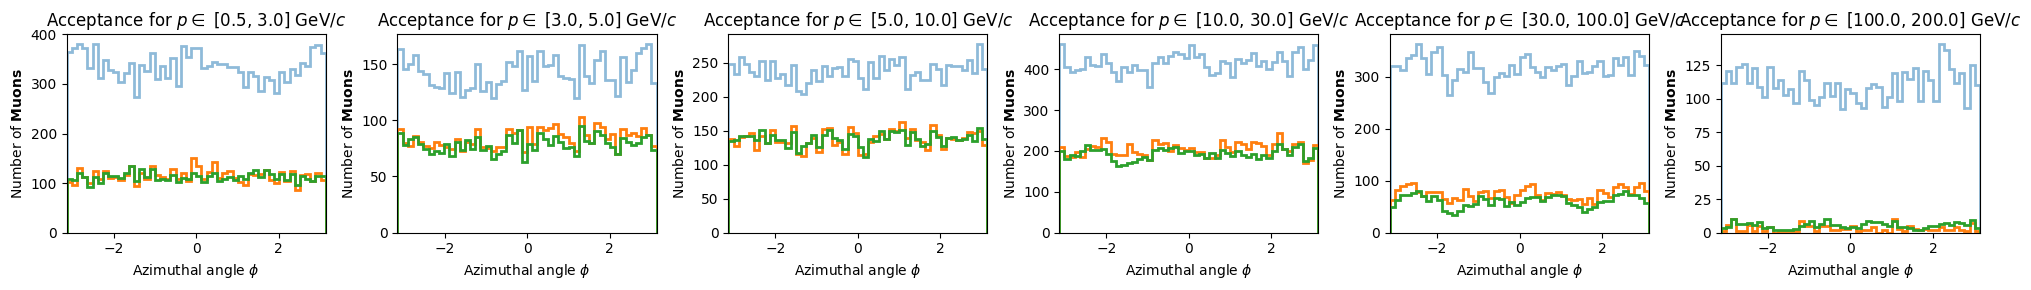

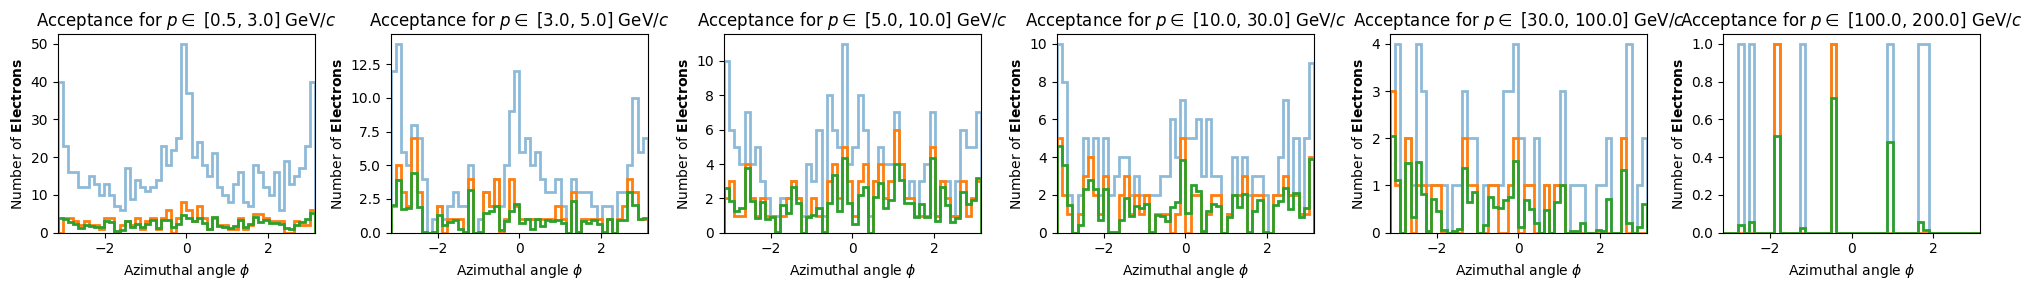

In [12]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"is_{part} and phi > -3.5 and phi < 3.5")[['acceptance', 'predicted', 'phi', 'log10_p']].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"log10_p > {np.log10(p_min)} and log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.phi.values, bins=np.linspace(-np.pi, np.pi, 51))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance').phi.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.phi.values, weights=bin_df.predicted.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Azimuthal angle $\phi$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()